In [1]:
import numpy as np
from lensing_data_class import LensingData
from cluster_local_tidy import ClusterLensing
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import lenstronomy.Util.constants as const
import pandas as pd
import corner
import arviz as az
import pathlib

In [2]:
import warnings

# Suppressing the lenstronomy warning on astropy.cosmology
from lenstronomy.LensModel.lens_model import LensModel
warnings.filterwarnings("ignore", category=UserWarning, module='lenstronomy.LensModel.lens_model')

# Lens data

scenarios = {
        '1': 'abell370',
        '2': 'abell2744',
        '3': 'abells1063',
        '4': 'macs0416',
        '5': 'macs0717',
        '6': 'macs1149'
    }

full_cluster_names = {
        'abell370': 'Abell 370',
        'abell2744': 'Abell 2744',
        'abells1063': 'Abell S1063',
        'macs0416': 'MACS J0416.1-2403',
        'macs0717': 'MACS J0717.5+3745',
        'macs1149': 'MACS J1149.5+2223'
    }

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []
data_sigma_dt_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_psi.fits'
    )
    sigma_dt_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_sigma_dt.fits'
    )   

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi, fits.open(sigma_dt_file) as hdul_sigma_dt:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data
        data_sigma_dt = hdul_sigma_dt[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)
        data_sigma_dt_list.append(data_sigma_dt)

# getting the pixel scale list
pixscale_list = [0.2, 0.3, 0.2, 0.3, 0.8, 0.5]
z_l_list = [0.375, 0.308, 0.351, 0.397, 0.545, 0.543]
lensing_data = LensingData(
    alpha_maps_x=datax_list,
    alpha_maps_y=datay_list,
    lens_potential_maps=data_psi_list,
    uncertainty_dt=data_sigma_dt_list,
    pixscale = pixscale_list,
    z_l_list = z_l_list, # Lens redshifts for the two clusters
    # We can use the default x_center, y_center, and search_window_list
    # or override them if needed.
)

# --- 3. Initialize the Main Analysis Class ---
# z_s_ref is a reference source redshift used for initial scaling calculations.
# It can be an estimate of the source's redshift.
z_s_ref = 1.5 
cluster_system = ClusterLensing(data=lensing_data, z_s_ref=z_s_ref)

print("Setup complete. Lensing system initialized.")

Setup complete. Lensing system initialized.


In [31]:
# Get the result from csv file
csv_file_path = os.path.join(os.getcwd(), 'src_pos_tidy_xyz.csv')
localized_data = pd.read_csv(csv_file_path)
# Assuming the CSV has columns 'x_src', 'y_src', 'z_s' for each cluster
index = localized_data['indices'].values
x = localized_data['x'].values
y = localized_data['y'].values
z = localized_data['z'].values
H0 = 70

lum_dist_true = []
time_delays_true = []
for i in range(len(x)):
    test_params = {"x_src" : x[i], "y_src": y[i], "z_s": z[i], "H0": H0}
    test_cluster = int(index[i])
    # Calculate the image positions and time delays for the test parameters
    output = cluster_system.calculate_imgs_delays_magns(
        test_params, test_cluster
    )
    
    cosmos = FlatLambdaCDM(H0=70, Om0=0.3)
    lum_dist_unlensed = cosmos.luminosity_distance(z[i]).value  # Luminosity distance in Mpc
    mu = output['magnifications']
    lum_dist_lensed = np.array([lum_dist_unlensed / np.abs(m) for m in mu])
    lum_dist_true.append(lum_dist_lensed)
    time_delays_true.append(output['time_delays'])
# # test image pos and dt
# index, x,y,z,H0 =3, 125.1862426095528,108.72131582359688,2.937492820554342, 70
# #print(x[0], y[0], z[0], H0)
# test_params = {"x_src" : x, "y_src": y, "z_s": z, "H0": H0}
# test_cluster = index
# # Calculate the image positions and time delays for the test parameters
# output = cluster_system.calculate_imgs_delays_magns(
#     test_params, test_cluster
# )
# print(output['time_delays'])
# print(output['image_positions'])
# print(output['magnifications'])
# dt_true = output['time_delays']

# # get its luminosity distance
# cosmos = FlatLambdaCDM(H0=70, Om0=0.3)
# lum_dist_unlensed = cosmos.luminosity_distance(z).value  # Luminosity distance in Mpc
# mu = output['magnifications']
# lum_dist_true = np.array([lum_dist_unlensed / np.abs(m) for m in mu])
# print("True luminosity distances:", lum_dist_unlensed)
# print("Lensed luminosity distances:", lum_dist_true)


In [ ]:
# merge the second smallest chi sq values from the second_smallest.csv file to the src_pos_tidy_xyz.csv file
second_smallest_df = pd.read_csv('/home/dices/Research/GWlensing_Brian/outputs/with_z/second_smallest.csv')
# Assuming the file_number corresponds to the index in localized_data
localized_data = pd.read_csv('src_pos_tidy_xyz.csv')
# delete the out_dir column if it exists
localized_data = localized_data.drop(columns=['out_dir'])
# Create a 'file_number' column in localized_data that corresponds to its row index
localized_data['file_number'] = localized_data.index

# Merge the two dataframes on the 'file_number' column
# 'how=left' ensures all rows from localized_data are kept
merged_df = pd.merge(localized_data, second_smallest_df, on='file_number', how='left')
# delete the 'file_number' column as it's no longer needed
merged_df = merged_df.drop(columns=['file_number'])
# Save the merged dataframe to the existing CSV file
merged_df.to_csv('src_pos_tidy_xyz.csv', index=False)

print("Merge complete. Data saved to 'src_pos_tidy_xyz.csv'")
print(merged_df.head())

KeyError: "['out_dir'] not found in axis"

In [ ]:
#calculating the difference between the smallest chi sq and the second smallest chi sq
merged_data = pd.read_csv('src_pos_tidy_xyz.csv')
bayes_factors = merged_data['second_smallest_chi2'] - merged_data['chi_sq']
merged_data['bayes_factor'] = bayes_factors
merged_data.to_csv('src_pos_tidy_xyz.csv', index=False)

Number of bayes factor values with chi_sq <= 20: 50


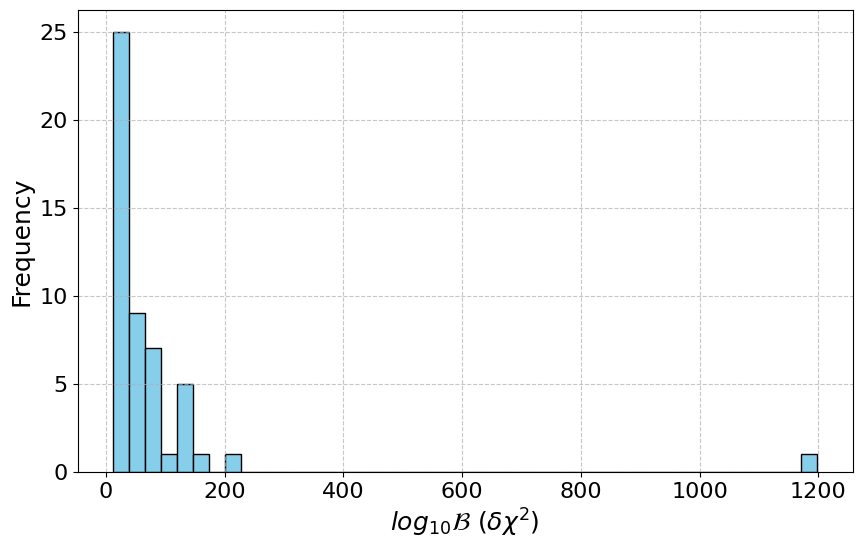

In [ ]:
# making the bayes factor histogram plot
data = pd.read_csv('src_pos_tidy_xyz.csv')
bayes_factors = data['bayes_factor'].values
# opt out the bayes_factor values if the value of chi_sq in the same row is larger than 100
chi_sq_values = data['chi_sq'].values
bayes_factors = bayes_factors[chi_sq_values <= 20]
print(f"Number of bayes factor values with chi_sq <= 20: {len(bayes_factors)}")
# bayes_factor are in ln base, change to log 10 base
bayes_factors *= np.log10(np.e)
#print(bayes_factors)

# getting the bin number using Freedman-Diaconis rule
def freedman_diaconis(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    bin_width = 2 * iqr * len(data) ** (-1/3)
    bin_count = int((data.max() - data.min()) / bin_width)
    return bin_count


plt.figure(figsize=(10, 6))
plt.hist(bayes_factors, color='skyblue', edgecolor='black', bins=freedman_diaconis(bayes_factors))
# add grid lines in x and y direction
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# set the font size of the ticks
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel(r'$log_{10} \mathcal{B}$ ($\delta \chi^2$)', fontsize=18)

plt.savefig('Report images sem2/new/bayes_factor_histogram_xyz.pdf', bbox_inches='tight')


Number of filtered npz files: 50


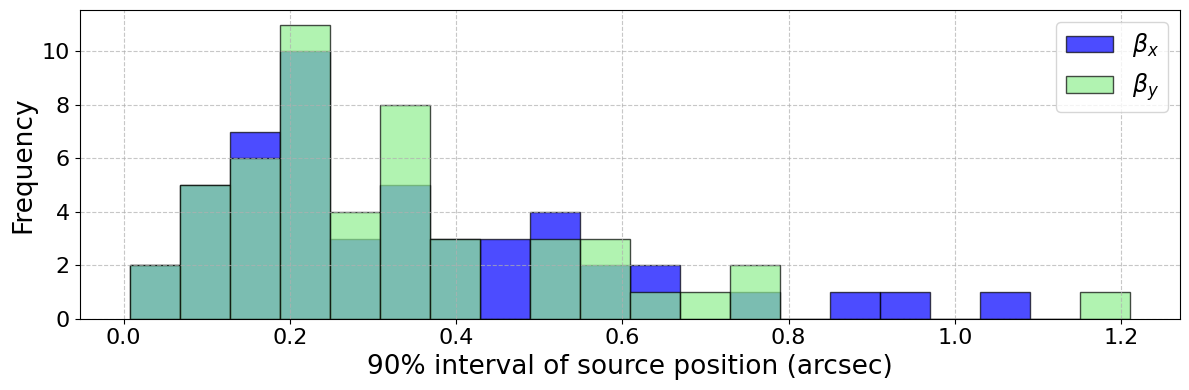

In [ ]:
import glob
from matplotlib.ticker import MaxNLocator
# make the plot of uncertainty in histogram
# get all the npz file from the folder
OUT_DIR = '/home/dices/Research/GWlensing_Brian/outputs/with_z_imgs'
# Search for .npz files in subdirectories matching the pattern 'row*'
npz_files = glob.glob(os.path.join(OUT_DIR, 'row*','test_tidy_row*', '*.npz'))
# drop the npz files if its folder contains more than 1 .npz file, or the corresponding chi sq value is larger than 20 in the corresponding src_pos_tidy_xyz.csv file
filtered_npz_files = []
accepted_rows = []
localized_data = pd.read_csv('src_pos_tidy_xyz.csv')
for npz_file in npz_files:
    # extract the row number from the npz file path
    row_number = int(pathlib.Path(npz_file).parts[-3][3:])  # 'rowX' -> X
    # get the chi sq value from the localized_data dataframe
    chi_sq_value = localized_data.loc[row_number, 'chi_sq']
    # count the number of npz files in the same folder
    folder_path = os.path.dirname(npz_file)
    num_npz_in_folder = len(glob.glob(os.path.join(folder_path, '*.npz')))
    if chi_sq_value <= 20 and num_npz_in_folder == 1:
        filtered_npz_files.append(npz_file)
        accepted_rows.append(row_number)

print(f"Number of filtered npz files: {len(filtered_npz_files)}")


all_uncertainties = []

# get the uncertainty from each npz file
for npz_file in filtered_npz_files:
    mcmc_data = np.load(npz_file)
    flat_chain = mcmc_data['flat_chain']
    # calculate the 90% credible interval as the uncertainty for the 3 parameters in the npz file
    uncertainty = np.percentile(flat_chain, 95, axis=0) - np.percentile(flat_chain, 5, axis=0)
    all_uncertainties.extend(uncertainty)
# rearrange the uncertainties into 3 separate lists for x, y, z, when the elements are arranged in [[x, y, z], [x, y, z],...]
uncertainties = np.array(all_uncertainties).reshape(-1, 3)
uncertainties_x = uncertainties[:, 0]
uncertainties_y = uncertainties[:, 1]
uncertainties_z = uncertainties[:, 2]
#print(uncertainties_x)
# plot the histogram of the uncertainties
fig, axs = plt.subplots(2, 1, figsize=(12, 8), tight_layout=True)

# Plot for x and y uncertainties combined
# Determine common bins for x and y uncertainties to ensure same bin widths
min_val = min(uncertainties_x.min(), uncertainties_y.min())
max_val = max(uncertainties_x.max(), uncertainties_y.max())
bins = np.linspace(min_val, max_val, 21)  # 20 bins

axs[0].hist(uncertainties_x, bins=bins, color='blue', edgecolor='black', alpha=0.7, label=r'$\beta_x$')
axs[0].hist(uncertainties_y, bins=bins, color='lightgreen', edgecolor='black', alpha=0.7, label=r'$\beta_y$')
axs[0].set_xlabel('90% interval of source position (arcsec)', fontsize=19)
axs[0].set_ylabel('Frequency', fontsize=19)
axs[0].grid(axis='both', linestyle='--', alpha=0.7)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend(fontsize=17)
axs[0].yaxis.set_major_locator(MaxNLocator(nbins=6,integer=True))

# Plot for z uncertainty
axs[1].hist(uncertainties_z, bins=20, color='salmon', edgecolor='black')
axs[1].set_xlabel('90% interval in z', fontsize=19)
axs[1].set_ylabel('Frequency', fontsize=19)
axs[1].grid(axis='both', linestyle='--', alpha=0.7)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].yaxis.set_major_locator(MaxNLocator(nbins=6,integer=True))

plt.savefig('Report images sem2/new/90_interval_xyz.pdf', bbox_inches='tight')


Number of filtered bayes factors: 50


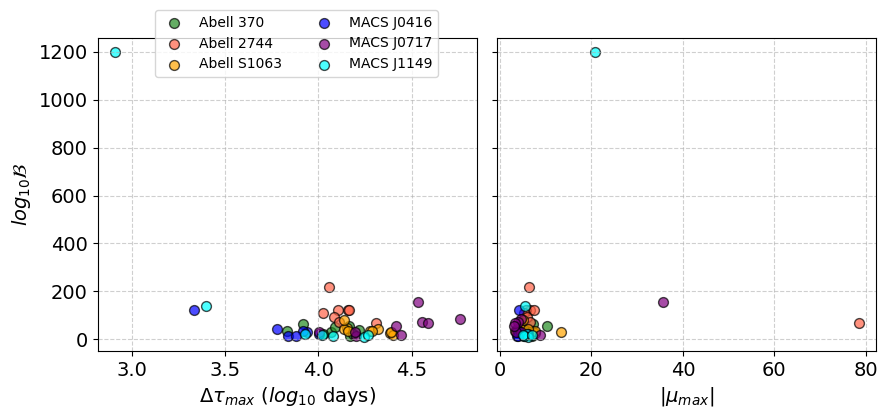

In [ ]:
# get the correlation map between the relative time delays, largest relative magnifications, and the bayes factor of the 60 events
# get the bayes factor from the src_pos_tidy_xyz.csv file
data = pd.read_csv('src_pos_tidy_xyz.csv')
bayes_factors = data['bayes_factor'].values
localized_index = data['localized_index'].values
localized_x = data['localized_x'].values
localized_y = data['localized_y'].values
localized_z = data['localized_z'].values
# for fix_z file
original_z = data['z'].values
filtered_original_z = []
# opt out the bayes_factor values if the value of chi_sq in the same row is larger than 20 or the number of .npz files in the corresponding folder is more than 1
chi_sq_values = data['chi_sq'].values
filtered_bayes_factors = []
filtered_localized_index = []
filtered_localized_x = []
filtered_localized_y = []
filtered_localized_z = []
for i in range(len(bayes_factors)):
    row_number = i
    chi_sq_value = chi_sq_values[i]
    folder_path = os.path.join(OUT_DIR, f'row{row_number}', f'test_tidy_row{row_number}')
    num_npz_in_folder = len(glob.glob(os.path.join(folder_path, '*.npz')))
    if chi_sq_value <= 20 and num_npz_in_folder == 1:
        filtered_bayes_factors.append(bayes_factors[i])
        filtered_localized_index.append(localized_index[i])
        filtered_localized_x.append(localized_x[i])
        filtered_localized_y.append(localized_y[i])
        filtered_localized_z.append(localized_z[i])

        filtered_original_z.append(original_z[i])
print(f"Number of filtered bayes factors: {len(filtered_bayes_factors)}")

# get the image positions, time delays, and magnifications from each x,y,z pair with the index
image_positions = []
time_delays = []
magnifications = []
for i in range(len(filtered_localized_x)):
    x = filtered_localized_x[i]
    y = filtered_localized_y[i]
    z = filtered_localized_z[i]
    index = filtered_localized_index[i]
    # use the clusterlensing class to calculate the image positions, time delays, and magnifications
    test_params = {"x_src" : x, "y_src": y, "z_s": z, "H0": 70}
    test_cluster = int(index)
    output = cluster_system.calculate_imgs_delays_magns(
        test_params, test_cluster
    )
    #print(test_params)
    #print(output['image_positions'])
    image_positions.append(output['image_positions'])
    largest_time_delay = np.max(output['time_delays']) - np.min(output['time_delays'])
    largest_magnification = np.max(np.abs(output['magnifications']))
    time_delays.append(largest_time_delay)
    magnifications.append(largest_magnification)

# print(time_delays)
filtered_bayes_factors = np.array(filtered_bayes_factors) * np.log10(np.e)
# plot the graph between the time delays, magnifications, and bayes factors separately by scatter plot
fig, axs = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True, sharey=True)

# Define a colormap and labels for the clusters
colors = ['forestgreen', 'tomato', 'orange', 'blue', 'purple', 'cyan']
cluster_labels = {
    0: 'Abell 370', 1: 'Abell 2744', 2: 'Abell S1063',
    3: 'MACS J0416', 4: 'MACS J0717', 5: 'MACS J1149'
}

# Plot for each cluster index to create a legend
for i in range(6):
    mask = np.array(filtered_localized_index) == i
    if np.any(mask):
        axs[0].scatter(np.log10(np.array(time_delays)[mask]), filtered_bayes_factors[mask], 
                       color=colors[i], s=50, marker='o', edgecolor='k', alpha=0.7, label=cluster_labels[i])

axs[0].set_xlabel(r'$\Delta \tau_{max}$ ($log_{10}$ days)', fontsize=14)
axs[0].set_ylabel(r'$log_{10} \mathcal{B}$', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].tick_params(axis='both', which='major', labelsize=14)

for i in range(6):
    mask = np.array(filtered_localized_index) == i
    if np.any(mask):
        axs[1].scatter(np.array(magnifications)[mask], filtered_bayes_factors[mask], 
                       color=colors[i], s=50, marker='o', edgecolor='k', alpha=0.7)
axs[1].set_xlabel(r'$|\mu_{max}|$', fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].tick_params(axis='both', which='major', labelsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True)

# axs[1].scatter(magnifications, filtered_bayes_factors, s=50, marker='o', edgecolor='k', alpha=0.7)
# axs[1].set_xlabel(r'$|\mu_{max}|$')

plt.tight_layout()
plt.savefig('Report images sem2/new/B_vs_dt_mu_xyz.pdf', bbox_inches='tight')

Number of events for cluster 0: 9
Number of events for cluster 1: 8
Number of events for cluster 2: 10
Number of events for cluster 3: 7
Number of events for cluster 4: 9
Number of events for cluster 5: 7


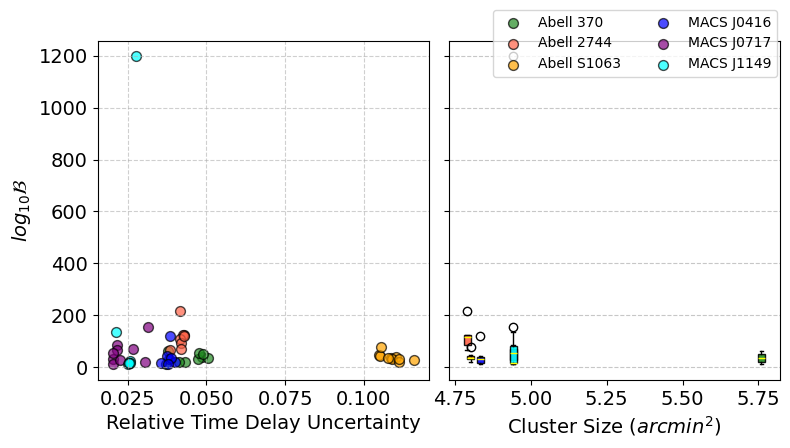

In [ ]:
# plot the time delay uncertainty, cluster size, z_s vs bayes factor
# get the time delay uncertainty of each image position
time_delay_uncertainties_largest = []
time_delay_uncertainties_all = []
for i in range(len(filtered_localized_x)):
    x_img = image_positions[i][0],
    y_img = image_positions[i][1],
    index = int(filtered_localized_index[i])
    time_delay_uncertainties = cluster_system.calculate_time_delay_uncertainty(
        [x_img, y_img], index
    )
    time_delay_uncertainties_largest.append(np.max(time_delay_uncertainties))
    time_delay_uncertainties_all.append(time_delay_uncertainties)
# plot the time delay uncertainty vs bayes factor
fig, axs = plt.subplots(1, 3, figsize=(12, 4.5), tight_layout=True, sharey=True)

# Define a colormap and labels for the clusters from cell 9
colors = ['forestgreen', 'tomato', 'orange', 'blue', 'purple', 'cyan']
cluster_labels = {
    0: 'Abell 370', 1: 'Abell 2744', 2: 'Abell S1063',
    3: 'MACS J0416', 4: 'MACS J0717', 5: 'MACS J1149'
}

# Plot for time delay uncertainty vs bayes factor
for i in range(6):
    mask = np.array(filtered_localized_index) == i
    if np.any(mask):
        print(f"Number of events for cluster {i}: {np.sum(mask)}")
        axs[0].scatter(np.array(time_delay_uncertainties_largest)[mask], np.array(filtered_bayes_factors)[mask], 
                       color=colors[i], s=50, marker='o', edgecolor='k', alpha=0.7, label=cluster_labels[i])
axs[0].set_xlabel(r'Relative Time Delay Uncertainty', fontsize=14)
axs[0].set_ylabel(r'$log_{10} \mathcal{B}$', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].tick_params(axis='both', which='major', labelsize=14)
# get the cluster size from the lensing data class
data_to_plot = [[] for _ in range(6)]
for index, bf in zip(filtered_localized_index, filtered_bayes_factors):
    data_to_plot[int(index)].append(bf)

data_by_cluster = [[] for _ in range(6)]
for index, bf in zip(filtered_localized_index, filtered_bayes_factors):
    data_by_cluster[int(index)].append(bf)

# Cluster sizes in the same order as the clusters (arcmin^2)
cluster_sizes = np.array([5.76, 4.791, 4.8024, 4.8347, 4.942, 4.942], dtype=float)

# Sort by cluster size
sorted_indices = np.argsort(cluster_sizes)
sorted_cluster_sizes = cluster_sizes[sorted_indices]
sorted_data_to_plot = [data_by_cluster[i] for i in sorted_indices]

# Set a reasonable box width based on spacing in cluster sizes
unique_sizes = np.unique(sorted_cluster_sizes)
if len(unique_sizes) > 1:
    spacing = np.min(np.diff(unique_sizes))
    box_width = 2 * spacing
else:
    box_width = 0.1 * unique_sizes[0]

# Create a box plot at x = cluster sizes (like the sample code)
box = axs[1].boxplot(
    sorted_data_to_plot,
    positions=sorted_cluster_sizes,
    widths=box_width,
    patch_artist=True,
    manage_ticks=False
)

# Color the boxes – same style as the sample code, but mapped from your cluster colors
box_colors = [colors[i] for i in sorted_indices]
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.9)

# Style medians to match the sample
for median in box['medians']:
    median.set_color('yellow')

axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_xlabel(r'Cluster Size ($arcmin^2$)', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

# plot the source redshift vs bayes factor
for i in range(6):
    mask = np.array(filtered_localized_index) == i
    if np.any(mask):
        axs[2].scatter(np.array(filtered_localized_z)[mask], np.array(filtered_bayes_factors)[mask], 
                       color=colors[i], s=50, marker='o', edgecolor='k', alpha=0.7)
axs[2].set_xlabel('Source Redshift z_s', fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].tick_params(axis='both', which='major', labelsize=14)

fig.legend(handles=axs[0].get_legend_handles_labels()[0], labels=cluster_labels.values(), loc='upper center', bbox_to_anchor=(0.8, 1.0), ncol=2, fancybox=True)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Report images sem2/new/B_vs_dt_size_z_xyz.pdf', bbox_inches='tight')


In [50]:
# perform the correlation test on the above three plots
from scipy.stats import spearmanr

# Correlation between time delay uncertainty and bayes factor
corr_dt, p_value_dt = spearmanr(time_delay_uncertainties_largest, filtered_bayes_factors)
print(f"Spearman Correlation between Time Delay Uncertainty and Bayes Factor: {corr_dt}, p-value: {p_value_dt}")

# Correlation between cluster size and bayes factor
cluster_size_array = np.array([cluster_sizes[int(idx)] for idx in filtered_localized_index])
corr_size, p_value_size = spearmanr(cluster_size_array, filtered_bayes_factors)
print(f"Spearman Correlation between Cluster Size and Bayes Factor: {corr_size}, p-value: {p_value_size}")

# Correlation between source redshift and bayes factor
corr_z, p_value_z = spearmanr(np.array(filtered_localized_z), filtered_bayes_factors)
print(f"Spearman Correlation between Source Redshift and Bayes Factor: {corr_z}, p-value: {p_value_z}")

Spearman Correlation between Time Delay Uncertainty and Bayes Factor: 0.11577430972388955, p-value: 0.4233403015698809
Spearman Correlation between Cluster Size and Bayes Factor: -0.3368374133115434, p-value: 0.01676060211712129
Spearman Correlation between Source Redshift and Bayes Factor: nan, p-value: nan


/tmp/ipykernel_54768/2874182452.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_z, p_value_z = spearmanr(np.array(filtered_localized_z), filtered_bayes_factors)


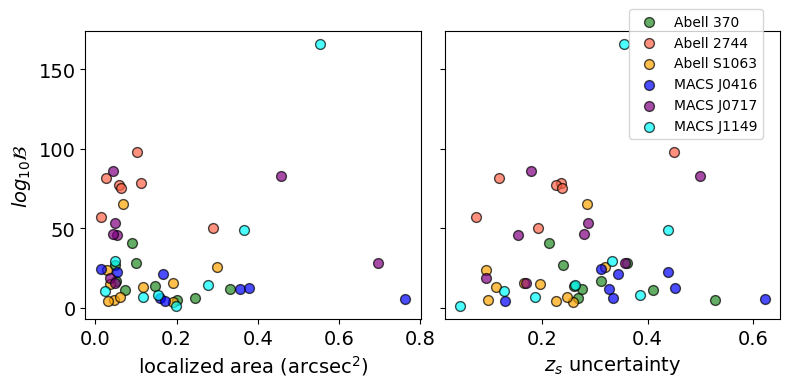

In [42]:
# plot the the graph between the 90% credible intervals, and bayes factors separately by scatter plot
# make the credible interval of x and y into the localized area in arcsec^2
localized_area = [uncertainties_x[i] * uncertainties_y[i] for i in range(len(uncertainties_x))]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
colors = ['forestgreen', 'tomato', 'orange', 'blue', 'purple', 'cyan']
cluster_labels = {
    0: 'Abell 370', 1: 'Abell 2744', 2: 'Abell S1063',
    3: 'MACS J0416', 4: 'MACS J0717', 5: 'MACS J1149'
}

for i in range(6):
    mask = np.array(filtered_localized_index) == i
    if np.any(mask):
        axs[0].scatter(np.array(localized_area)[mask], np.array(filtered_bayes_factors)[mask], 
                       color=colors[i], s=50, marker='o', edgecolor='k', alpha=0.7, label=cluster_labels[i])
axs[0].set_xlabel('localized area (arcsec$^2$)', fontsize=14)
axs[0].set_ylabel(r'$log_{10} \mathcal{B}$', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

for i in range(6):
    mask = np.array(filtered_localized_index) == i
    if np.any(mask):
        axs[1].scatter(np.array(uncertainties_z)[mask], np.array(filtered_bayes_factors)[mask], 
                       color=colors[i], s=50, marker='o', edgecolor='k', alpha=0.7, label=cluster_labels[i])
axs[1].set_xlabel(r'$z_s$ uncertainty', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
plt.legend(handles=axs[0].get_legend_handles_labels()[0], labels=cluster_labels.values(), loc='upper center', bbox_to_anchor=(0.75, 1.1), ncol=1, fancybox=True)
plt.tight_layout()
plt.savefig('Report images sem2/new/B_vs_area_deltaz_xyz.pdf', bbox_inches='tight')

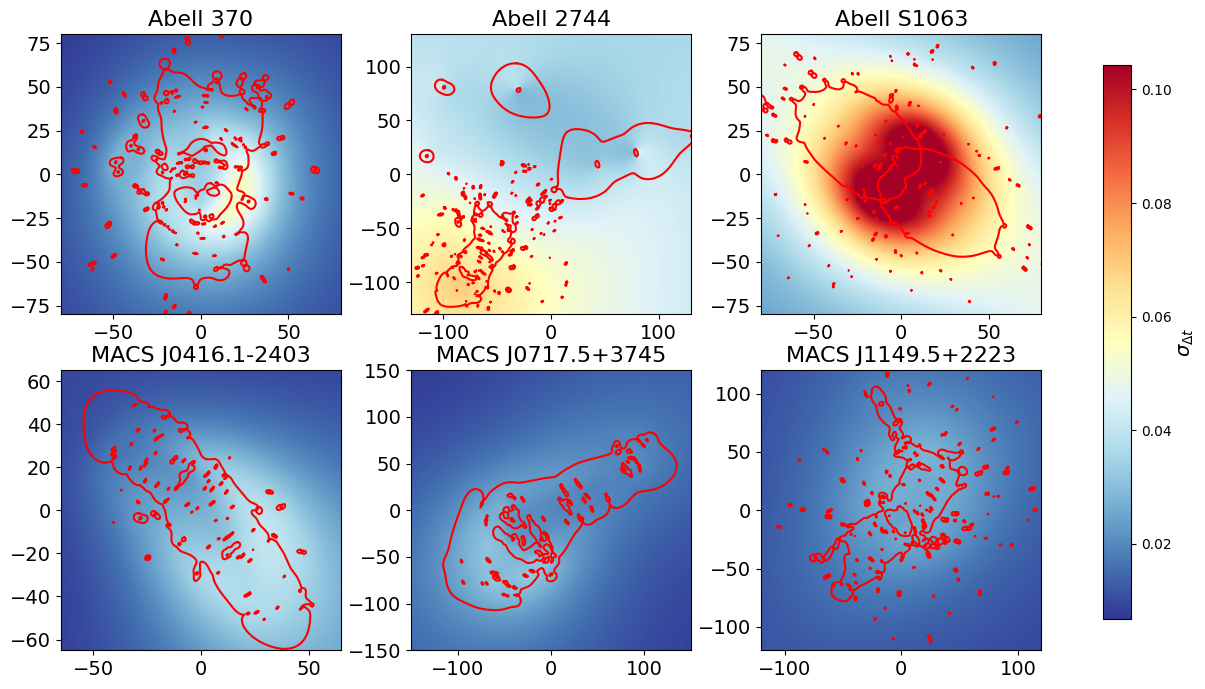

In [13]:
from matplotlib.colors import PowerNorm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Plots import lens_plot
# ---- cluster meta ----
Clusters = ["Abell 370", "Abell 2744", "Abell S1063",
            "MACS J0416.1-2403", "MACS J0717.5+3745", "MACS J1149.5+2223"]
clusters = ["abell370", "abell2744", "abells1063", "macs0416", "macs0717", "macs1149"]
sidepix = [800, 1200, 1000, 800, 600, 600]
pixscale_list = [0.2, 0.3, 0.2, 0.3, 0.8, 0.5]

# ---- load sigma_tau maps ----
sigma_tau_maps = []
for i in range(len(Clusters)):
    fits_file = f'/home/dices/Research/GWlensing_Brian/GCdata/{Clusters[i]}/cats copy/hlsp_frontier_model_{clusters[i]}_cats_v4_sigma_dt.fits'
    sigma_tau_map = fits.getdata(fits_file)
    sigma_tau_maps.append(sigma_tau_map)

# ---- compute global color scale ----
all_vals = np.concatenate([m.ravel() for m in sigma_tau_maps])
all_vals = all_vals[np.isfinite(all_vals)]

vmin, vmax = np.percentile(all_vals, [1, 99])
norm = PowerNorm(gamma=1, vmin=vmin, vmax=vmax)

cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))

for index in range(6):
    # -----------------------
    # 1) BACKGROUND: sigma_dt map
    # -----------------------
    sigma_tau_map = sigma_tau_maps[index]
    sidepix_val   = sidepix[index]
    pixscale      = float(pixscale_list[index])

    # physical half-size in arcsec (this is your "n")
    L   = sidepix_val * pixscale         # total size (0 .. L in old code)
    n   = L / 2.0                        # we will use -n .. +n
    ax  = axs[index // 3, index % 3]

    # extent centered at 0: [-n, +n] on both axes
    im = ax.imshow(
        sigma_tau_map,
        origin='lower',
        cmap='RdYlBu_r',
        norm=norm,
        extent=[-n, +n, -n, +n],         # <- coordinates from -n to +n
    )

    # -----------------------
    # 2) OVERLAY: critical curves from lenstronomy
    # -----------------------
    lm = LensModel(lens_model_list=["INTERPOL"],
                   z_lens=z_l_list[index],
                   cosmo=cosmology)

    fx  = np.asarray(datax_list[index])      # α_x
    fy  = np.asarray(datay_list[index])      # α_y
    psi = np.asarray(data_psi_list[index])   # potential

    ny, nx = fx.shape
    pixscale_lens = float(pixscale_list[index])  # arcsec / pixel

    # centered, ascending grids (match lenstronomy expectation)
    x_grid = (np.arange(nx) - (nx - 1) / 2.0) * pixscale_lens
    y_grid = (np.arange(ny) - (ny - 1) / 2.0) * pixscale_lens

    # enforce ascending y for lenstronomy; flip fields if necessary
    if y_grid[0] > y_grid[-1]:
        y_grid = y_grid[::-1]
        fx  = fx [::-1, :]
        fy  = fy [::-1, :]
        psi = psi[::-1, :]

    kwargs_lens = [{
        "grid_interp_x": x_grid,
        "grid_interp_y": y_grid,
        "f_":  psi,
        "f_x": fx,
        "f_y": fy,
    }]

    numpix = max(nx, ny)
    lens_plot.lens_model_plot(
        ax, lm, kwargs_lens,
        numPix=numpix,
        deltaPix=pixscale_lens,
        with_caustics=True,
        with_critical_curves=True,
        with_convergence=False,              # no extra background
        kwargs_caustics={"color_caustic": (1, 0, 0, 0)},  # invisible caustics
        kwargs_crit={"color": "cyan", "linewidth": 1.5},  # visible critical curves
    )

    # remove dummy 'caustics' legend entry if present
    for ln in ax.get_lines():
        if ln.get_label() == "caustics":
            ln.remove()
    # remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=14)
    ax.set_title(Clusters[index], fontsize=16)


# -----------------------
# 3) Per-panel axis limits (same as in your first script)
#    These are already symmetric: [-a, +a].
# -----------------------
axs[0, 1].set_xlim(-130, 130); axs[0, 1].set_ylim(-130, 130)
axs[0, 2].set_xlim(-80, 80);   axs[0, 2].set_ylim(-80, 80)
axs[1, 0].set_xlim(-65, 65);   axs[1, 0].set_ylim(-65, 65)
axs[1, 1].set_xlim(-150, 150); axs[1, 1].set_ylim(-150, 150)
axs[1, 2].set_xlim(-120, 120); axs[1, 2].set_ylim(-120, 120)

# -----------------------
# 4) Common colorbar
# -----------------------
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.9)
cbar.set_label(r'$\sigma_{\Delta t}$', fontsize=14)
plt.savefig('Report images sem2/new/sigma_dt_maps.pdf', bbox_inches='tight')


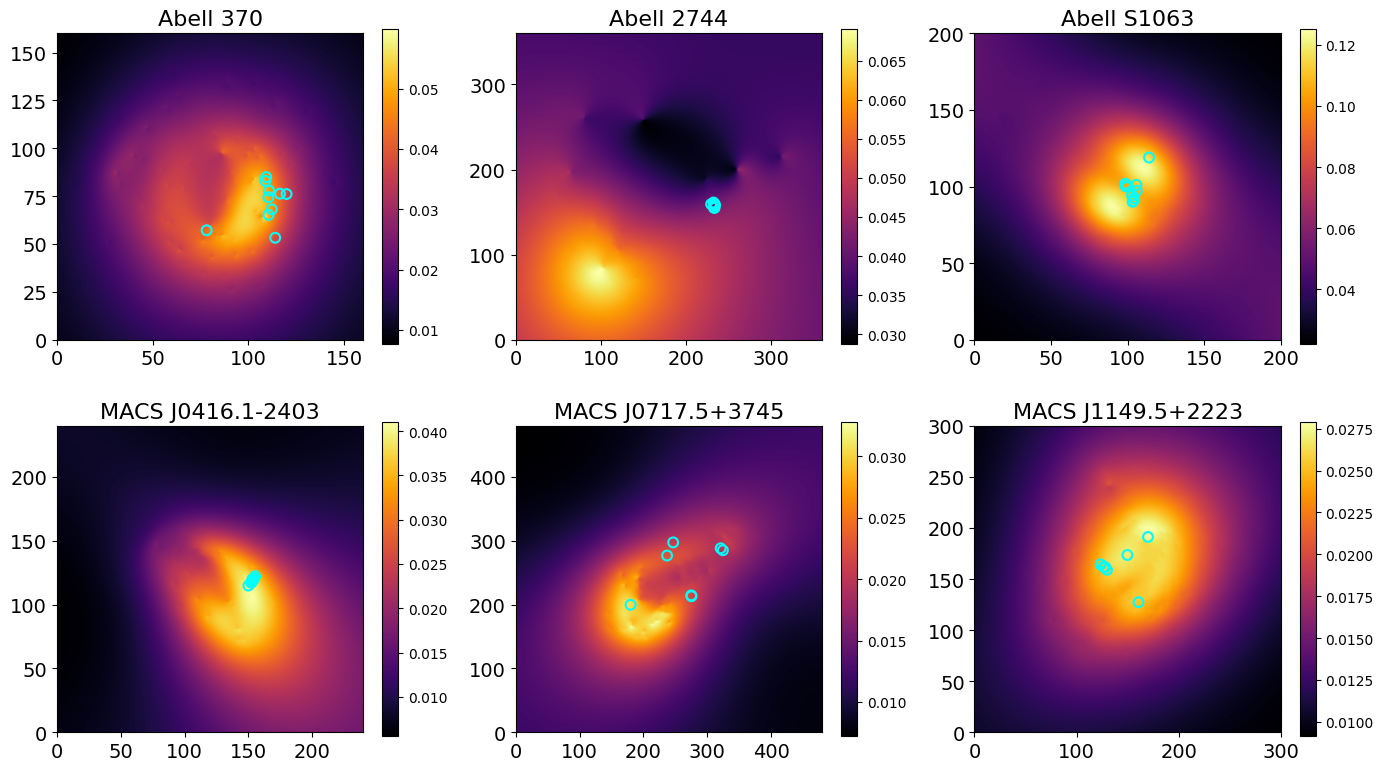

In [10]:

# ---- load maps (unchanged) ----
Clusters = ["Abell 370", "Abell 2744", "Abell S1063",
            "MACS J0416.1-2403", "MACS J0717.5+3745", "MACS J1149.5+2223"]
clusters = ["abell370", "abell2744", "abells1063", "macs0416", "macs0717", "macs1149"]
sigma_tau_maps = []
sidepix = [800, 1200, 1000, 800, 600, 600]
pixscale_list = [0.2, 0.3, 0.2, 0.3, 0.8, 0.5]

sigma_tau_maps = []
for i in range(len(Clusters)):
    fits_file = f'/home/dices/Research/GWlensing_Brian/GCdata/{Clusters[i]}/cats copy/hlsp_frontier_model_{clusters[i]}_cats_v4_sigma_dt.fits'
    sigma_tau_map = fits.getdata(fits_file)
    sigma_tau_maps.append(sigma_tau_map)

fig, axes = plt.subplots(2, 3, figsize=(14, 8)) 
for ax, sigma_tau_map, Name, sidepix_val, pixscale in zip(axes.flatten(), sigma_tau_maps, Clusters, sidepix, pixscale_list): 
    im = ax.imshow(sigma_tau_map, origin='lower', cmap='inferno', extent=[0, sidepix_val*pixscale, 0, sidepix_val*pixscale]) 
    ax.set_title(f"{Name}", fontsize=16) 
    ax.tick_params(axis='both', which='major', labelsize=14) 
    fig.colorbar(im, ax=ax, shrink=0.9)

# plot the image positions on top of the sigma dt maps for each cluster, they're in the image_positions 
for i in range(6):
    ax = axes.flatten()[i]
    # Iterate through each event that belongs to the current cluster
    for event_idx, cluster_idx in enumerate(filtered_localized_index):
        if int(cluster_idx) == i:
            # Get the data for this specific event
            positions = image_positions[event_idx]
            all_unc = time_delay_uncertainties_all[event_idx]
            largest_unc = time_delay_uncertainties_largest[event_idx]
            
            x_imgs, y_imgs = positions[0], positions[1]

            # Find the index of the image with the largest uncertainty
            # Using np.isclose for robust float comparison
            indices_to_plot = np.where(np.isclose(all_unc, largest_unc))[0]

            # Plot the image(s) that match the largest uncertainty
            
            ax.scatter(x_imgs[indices_to_plot], y_imgs[indices_to_plot], s=50, edgecolor='cyan', facecolor='none', marker='o', linewidth=1.5)

plt.tight_layout()
#plt.savefig('Report images sem2/new/sigma_dt_maps_with_img_pos.pdf', bbox_inches='tight')

[np.float64(0.019300516868735206), np.float64(0.041487330867038125), np.float64(0.046875153186088654), np.float64(0.011449112697221934), np.float64(0.01275659512146587), np.float64(0.014107251325092256)]


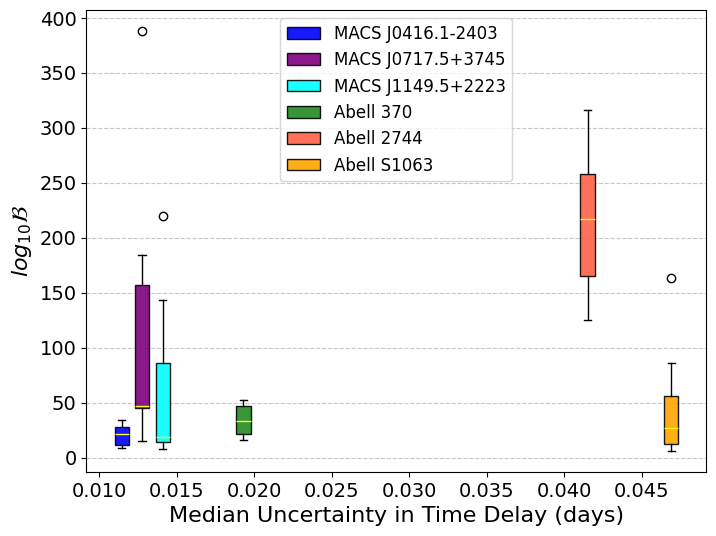

In [11]:
# get the bayes factor vs median uncertainty of sigma dt of each cluster plot
# get the median uncertainty of sigma dt from each simga_dt map

median_uncertainties = []
for i in range(len(sigma_tau_maps)):
    sigma_tau_map = sigma_tau_maps[i]
    # get the median uncertainty of the sigma tau map
    median_uncertainty = np.median(sigma_tau_map[np.isfinite(sigma_tau_map)])
    median_uncertainties.append(median_uncertainty)
print(median_uncertainties)

# sort the median uncertainties and corresponding cluster names
sorted_indices = np.argsort(median_uncertainties)
sorted_median_uncertainties = np.array(median_uncertainties)[sorted_indices]
sorted_cluster_names = np.array(Clusters)[sorted_indices]
# get the average bayes factor of each cluster from the filtered_bayes_factors and filtered_localized_index
average_bayes_factors = []
for i in range(len(Clusters)):
    mask = np.array(filtered_localized_index) == i
    average_bayes_factor = np.mean(np.array(filtered_bayes_factors)[mask])
    average_bayes_factors.append(average_bayes_factor)
sorted_average_bayes_factors = np.array(average_bayes_factors)[sorted_indices]  
# plot the graph
plt.figure(figsize=(8, 6))

# Collect Bayes factors by cluster
data_to_plot = [[] for _ in range(len(Clusters))]
for index, bf in zip(filtered_localized_index, filtered_bayes_factors):
    data_to_plot[int(index)].append(bf)

# Sort by median uncertainty
sorted_data_to_plot = [data_to_plot[i] for i in sorted_indices]

# Set a reasonable box width based on spacing in median uncertainties
sorted_median_uncertainties = np.array(sorted_median_uncertainties, dtype=float)
if len(sorted_median_uncertainties) > 1:
    spacing = np.min(np.diff(sorted_median_uncertainties))
    box_width = 0.7 * spacing
else:
    box_width = 0.1 * sorted_median_uncertainties[0]

# Boxplot at x = median uncertainties
box = plt.boxplot(
    sorted_data_to_plot,
    positions=sorted_median_uncertainties,
    widths=box_width,
    patch_artist=True,
    manage_ticks=False
)

# Color the boxes (same order as sorted clusters)
box_colors = ['blue', 'purple', 'cyan', 'forestgreen', 'tomato', 'orange']
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.9)

# Style medians / whiskers if you like
for median in box['medians']:
    median.set_color('yellow')


plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-ticks at the median uncertainties, labels are the numeric values
# plt.xticks(
#     ticks=sorted_median_uncertainties,
#     labels=[f"{val:.2f}" for val in sorted_median_uncertainties],
#     rotation=45
# )

plt.xlabel('Median Uncertainty in Time Delay (days)', fontsize=16)
plt.ylabel(r'$log_{10} \mathcal{B}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(
           labels=sorted_cluster_names, loc='upper center', fontsize=12)
#plt.savefig('Report images sem2/new/B_vs_median_dt_uncertainty_boxplot.pdf',bbox_inches='tight')


[np.float64(0.05977637332914423), np.float64(0.06899198916568028), np.float64(0.12502751119811162), np.float64(0.041033048595278725), np.float64(0.03278973570123809), np.float64(0.027904199529341343)]


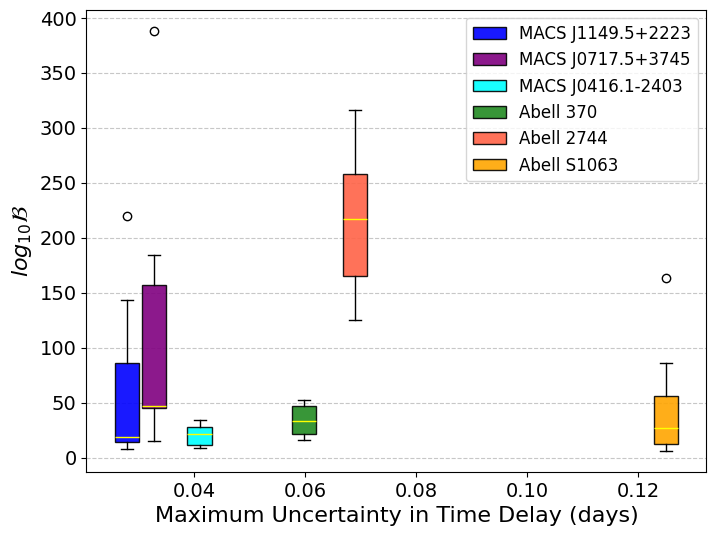

In [12]:
# make the same plot but with maximum uncertainty of sigma dt
max_uncertainties = []
for i in range(len(sigma_tau_maps)):
    sigma_tau_map = sigma_tau_maps[i]
    # get the max uncertainty of the sigma tau map
    max_uncertainty = np.max(sigma_tau_map[np.isfinite(sigma_tau_map)])
    max_uncertainties.append(max_uncertainty)
print(max_uncertainties)
# sort the median uncertainties and corresponding cluster names
sorted_indices = np.argsort(max_uncertainties)
sorted_max_uncertainties = np.array(max_uncertainties)[sorted_indices]
sorted_cluster_names = np.array(Clusters)[sorted_indices]
# get the average bayes factor of each cluster from the filtered_bayes_factors and filtered_localized_index
average_bayes_factors = []
for i in range(len(Clusters)):
    mask = np.array(filtered_localized_index) == i
    average_bayes_factor = np.mean(np.array(filtered_bayes_factors)[mask])
    average_bayes_factors.append(average_bayes_factor)
sorted_average_bayes_factors = np.array(average_bayes_factors)[sorted_indices]  
# plot the graph
plt.figure(figsize=(8, 6))

# Collect Bayes factors by cluster
data_to_plot = [[] for _ in range(len(Clusters))]
for index, bf in zip(filtered_localized_index, filtered_bayes_factors):
    data_to_plot[int(index)].append(bf)

# Sort by median uncertainty
sorted_data_to_plot = [data_to_plot[i] for i in sorted_indices]

# Set a reasonable box width based on spacing in median uncertainties
sorted_max_uncertainties = np.array(sorted_max_uncertainties, dtype=float)
if len(sorted_max_uncertainties) > 1:
    spacing = np.min(np.diff(sorted_max_uncertainties))
    box_width = 0.9 * spacing
else:
    box_width = 0.1 * sorted_max_uncertainties[0]

# Boxplot at x = median uncertainties
box = plt.boxplot(
    sorted_data_to_plot,
    positions=sorted_max_uncertainties,
    widths=box_width,
    patch_artist=True,
    manage_ticks=False
)

# Color the boxes (same order as sorted clusters)
box_colors = ['blue', 'purple', 'cyan', 'forestgreen', 'tomato', 'orange']
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.9)

# Style medians / whiskers if you like
for median in box['medians']:
    median.set_color('yellow')


plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-ticks at the median uncertainties, labels are the numeric values
# plt.xticks(
#     ticks=sorted_median_uncertainties,
#     labels=[f"{val:.2f}" for val in sorted_median_uncertainties],
#     rotation=45
# )

plt.xlabel('Maximum Uncertainty in Time Delay (days)', fontsize=16)
plt.ylabel(r'$log_{10} \mathcal{B}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(
           labels=sorted_cluster_names, loc='upper right', fontsize=12)